In [6]:
from daily_questions import DailyQuestions
from IPython.core.display import display, HTML
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
register_matplotlib_converters()

Enter the parametrs of the Daily Questions report
  * log_file: path to the text file with the raw data
  * n_days: number of days to show in the daily report
  * n_months: number of months to show in the month report
  * print_only_decimals: flag to turn on/off leading zeros before a decial (0.5 or .5)
  * censor_questions: flag to insert * characters to censor questions

In [7]:
log_file = '/Users/sergio/Dropbox/Reference/Automation/logDailyQuestions.txt'
dq = DailyQuestions(log_file, n_days=20, n_months= 3, print_only_decimals = True, censor_questions = True)

Run the last cell to generate the report

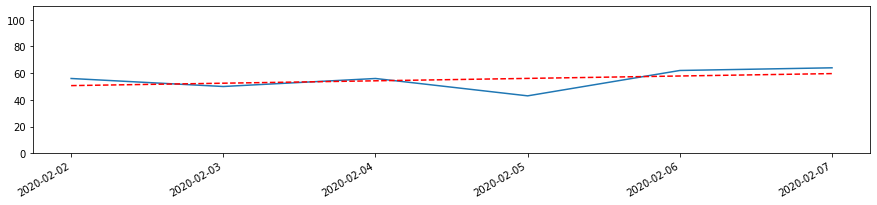

In [8]:
rows_read, rows_inserted = dq.loadContent()
days_html = dq.table_last_n_days()
months_html = dq.table_last_n_months()
statistics_html = dq.get_statistics()
display(HTML(days_html+months_html+statistics_html))
plt.show(dq.display_last_n_months_line_chart())